## Initial Stenosis model comparision experiments
### Notes:
**For all models apart from YOLO I used the StenUNet (https://arxiv.org/pdf/2310.14961) preprocessing method, the StenUNet augmentations, and to compare the impact of StenUNet's post processing algorithm, I ran each model with and without post-processing.**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def add_pp_label(df):
    df.index = [
    f"{label} (PostProc)" if i % 2 == 1 else label
    for i, label in enumerate(df.index)]

def plot_bars(df, metric, width, x, ax):
    ax.bar(x - width/2, df[metric][::2], width, edgecolor='black', color='seagreen', label='Original')
    ax.bar(x + width/2, df[metric][1::2], width, edgecolor='black', color='skyblue', label='PostProcessed')

    for i, (v1, v2) in enumerate(zip(df[metric][::2], df[metric][1::2])):
        ax.text(i - 0.28, v1+0.01, f"{v1:.4f}", ha='center', va='bottom', fontsize=9)
        ax.text(i + 0.28, v2+0.01, f"{v2:.4f}", ha='center', va='bottom', fontsize=9)

    ax.set_xticks(x)
    ax.set_xticklabels(df.index[::2], rotation=45, ha='right') 
    ax.grid(alpha=0.5)   

In [3]:
data = pd.read_csv("scores/orig_scores.csv", index_col='Model')
add_pp_label(data)
data

,Jaccard,F1,Recall,Precision,Acc,F2,HD,MFPS,MSPF
deeplabv3resnet101,0.4335,0.5758,0.6053,0.6402,0.9920,0.5824,3.5714,234.683708,0.000014
deeplabv3resnet101 (PostProc),0.4337,0.5758,0.6050,0.6457,0.9921,0.5823,3.5750,234.683708,0.000014
attentionunet,0.4214,0.5618,0.6339,0.5879,0.9912,0.5904,3.4743,498.900611,0.000007
attentionunet (PostProc),0.4221,0.5620,0.6331,0.5930,0.9913,0.5901,3.4774,498.900611,0.000007
yolov8x-seg,0.3234,0.4244,0.4315,0.7354,0.9914,0.4205,4.0100,102.040816,0.009800
yolov8x-seg (PostProc),0.3163,0.4183,0.4124,0.7452,0.9915,0.4075,3.9999,102.040816,0.009800
resunetplusplus,0.2516,0.3672,0.4339,0.3720,0.9851,0.3938,3.8237,322.748255,0.000010
resunetplusplus (PostProc),0.2520,0.3674,0.4335,0.3800,0.9851,0.3937,3.8279,322.748255,0.000010
transunet,0.0433,0.0741,0.1016,0.5846,0.9839,0.0827,4.5839,311.826157,0.000011
transunet (PostProc),0.0430,0.0735,0.1005,0.6079,0.9839,0.0819,4.5873,311.826157,0.000011


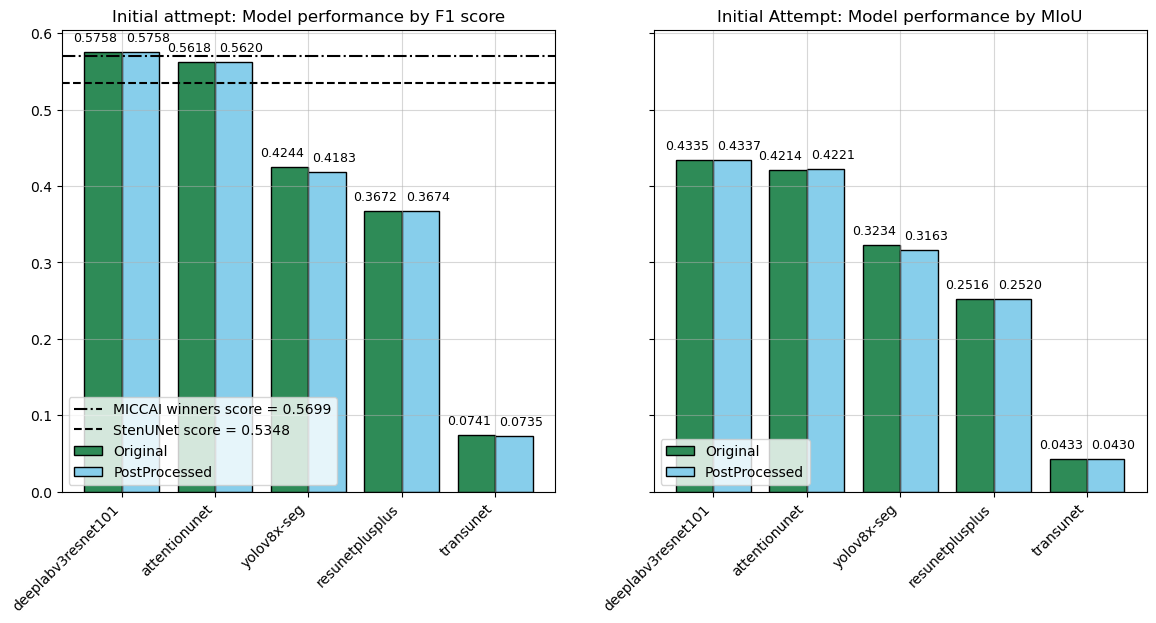

In [4]:
fig, (ax, ax1) = plt.subplots(1,2,figsize=(14,6), sharey=True)
x = np.arange(len(data) // 2)
width = 0.4

### first plot
plot_bars(data, 'F1', width, x, ax)

ax.axhline(0.5699, color='black', linestyle='dashdot', label='MICCAI winners score = 0.5699')
ax.axhline(0.5348, color='black', linestyle='dashed', label='StenUNet score = 0.5348')

ax.set(title='Initial attmept: Model performance by F1 score')
ax.legend(loc='lower left')

### second plot
plot_bars(data, 'Jaccard', width, x, ax1)
ax1.set(title='Initial Attempt: Model performance by MIoU')
ax1.legend(loc='lower left')

plt.show()

## Comments
- StenUnet's post processing algorithm only improved results for ResUNet++ and attention UNet. It actually reduced the scores for YOLOv8 and TransUNet. This may or may not be due to the threshold chosen
- TransUNet underperformed. I think this is due to the model oversegmenting, and getting distracted by the entire vessel overall rather than just the area of stenosis.
- DeepLabV3ResNet101 (in built torch model) actually managed to **just** beat the MICCAI winners by 0.007
- AttentionUNet beat the StenUNet score but not the MICCAI winners.

## Next steps
- Quick experiment with post processing threshold
- Experiment with different optimisers? They all used Adam, apart from YOLO which I left as auto and transunet as sgd
- Add my own block to one of the models to try and improve - maybe add a residual block/s to Attention UNet

# Threshold study found that the original threshold (50) was appropriate:

In [5]:
pp_data = pd.read_csv('scores/pp_scores.csv')
pp_data = pp_data.drop([2,4,6,8,10])
pp_data.at[0,'Threshold'] = 'thresh_0'
pp_data

,Model,Threshold,Jaccard,F1,Recall,Precision,Acc,F2,HD,MFPS,MSPF
0,attentionunet,thresh_0,0.4214,0.5618,0.6339,0.5879,0.9912,0.5904,3.4743,497.386047,0.000007
1,attentionunet,thresh_25,0.4217,0.5618,0.6334,0.5918,0.9912,0.5901,3.4770,497.386047,0.000007
3,attentionunet,thresh_50,0.4221,0.5620,0.6331,0.5930,0.9913,0.5901,3.4774,615.190917,0.000005
5,attentionunet,thresh_75,0.4220,0.5615,0.6323,0.5922,0.9913,0.5894,3.4830,611.956655,0.000005
7,attentionunet,thresh_100,0.4220,0.5612,0.6317,0.5960,0.9913,0.5890,3.4845,601.562457,0.000006
9,attentionunet,thresh_125,0.4219,0.5607,0.6306,0.5963,0.9913,0.5882,3.4895,582.899788,0.000006
11,attentionunet,thresh_150,0.4211,0.5594,0.6294,0.5959,0.9913,0.5870,3.4971,575.370864,0.000006


/tmp/ipykernel_16023/1408403060.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(pp_data['Threshold'], rotation=45, ha='right')


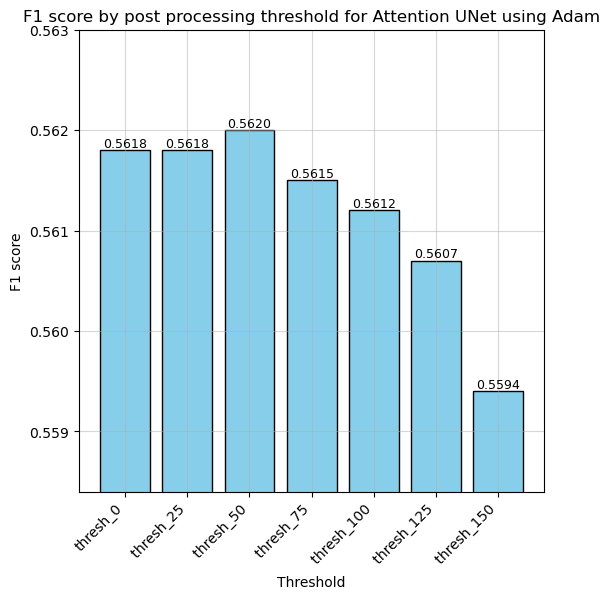

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6,6))

ax.bar(pp_data['Threshold'], pp_data['F1'], color='skyblue', edgecolor='black')

for i, v in enumerate(pp_data['F1']):
    ax.text(i, v, f"{v:.4f}", ha='center', va='bottom', fontsize=9)

ax.grid(alpha=0.5)
ax.set(title='F1 score by post processing threshold for Attention UNet using Adam', xlabel='Threshold', ylabel='F1 score')
ax.set_xticklabels(pp_data['Threshold'], rotation=45, ha='right')
plt.ylim(min(pp_data['F1'])-0.001, max(pp_data['F1'])+0.001)
plt.show()

# Conducted Optimiser Experiment for the top three performing models above:

In [7]:
opt_data = pd.read_csv('scores/opt_scores.csv', index_col='Model')
opt_data

,Optimiser,Jaccard,F1,Recall,Precision,Acc,F2,HD,MFPS,MSPF
Model,,,,,,,,,,
deeplabv3resnet101,RMSprop,0.4361,0.5795,0.6535,0.6015,0.9915,0.6087,3.4558,241.859821,0.000014
deeplabv3resnet101,RMSprop,0.4364,0.5797,0.6532,0.6022,0.9915,0.6087,3.4569,241.859821,0.000014
deeplabv3resnet101,adam,0.4335,0.5758,0.6053,0.6402,0.9920,0.5824,3.5714,234.683708,0.000014
deeplabv3resnet101,adam,0.4337,0.5758,0.6050,0.6457,0.9921,0.5823,3.5750,234.683708,0.000014
deeplabv3resnet101,SGD,0.3401,0.4735,0.5984,0.4890,0.9886,0.5255,3.7720,245.597627,0.000014
deeplabv3resnet101,SGD,0.3399,0.4730,0.5977,0.4953,0.9886,0.5250,3.7743,245.597627,0.000014
attentionunet,RMSprop,0.3864,0.5269,0.5925,0.5548,0.9906,0.5527,3.5288,472.811087,0.000007
attentionunet,RMSprop,0.3873,0.5276,0.5919,0.5583,0.9907,0.5528,3.5322,472.811087,0.000007
attentionunet,adam,0.4214,0.5618,0.6339,0.5879,0.9912,0.5904,3.4743,498.900611,0.000007


In [8]:
# dlv3_opt=opt_data[opt_data.index=='deeplabv3resnet101']
# dlv3_opt.index=dlv3_opt['Optimiser']
# aunet_opt=opt_data[opt_data.index=='attentionunet']
# aunet_opt.index=aunet_opt['Optimiser']
# yolo_opt = opt_data[opt_data.index=='yolov8x-seg']
# yolo_opt.index = yolo_opt['Optimiser']

df_stores = {}
for name in opt_data.index.unique():
    temp = opt_data[opt_data.index==name]
    temp.index = temp['Optimiser']
    df_stores[name] = temp

print(df_stores['deeplabv3resnet101'])

          Optimiser  Jaccard      F1  Recall  Precision     Acc      F2  \
Optimiser                                                                 
RMSprop     RMSprop   0.4361  0.5795  0.6535     0.6015  0.9915  0.6087   
RMSprop     RMSprop   0.4364  0.5797  0.6532     0.6022  0.9915  0.6087   
adam           adam   0.4335  0.5758  0.6053     0.6402  0.9920  0.5824   
adam           adam   0.4337  0.5758  0.6050     0.6457  0.9921  0.5823   
SGD             SGD   0.3401  0.4735  0.5984     0.4890  0.9886  0.5255   
SGD             SGD   0.3399  0.4730  0.5977     0.4953  0.9886  0.5250   

               HD        MFPS      MSPF  
Optimiser                                
RMSprop    3.4558  241.859821  0.000014  
RMSprop    3.4569  241.859821  0.000014  
adam       3.5714  234.683708  0.000014  
adam       3.5750  234.683708  0.000014  
SGD        3.7720  245.597627  0.000014  
SGD        3.7743  245.597627  0.000014  


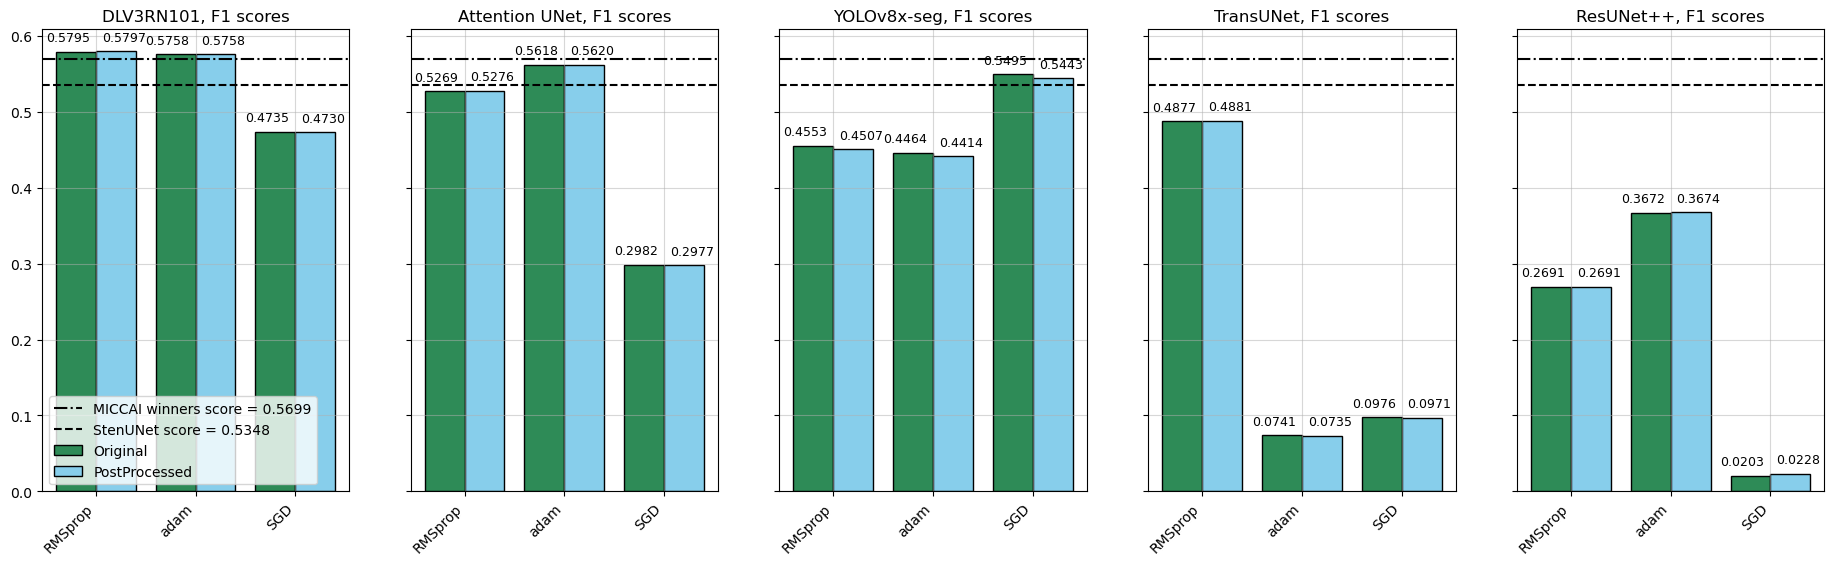

In [12]:
x = np.arange(len(data) // 3)
width = 0.4

fig, (ax,ax1,ax2,ax3,ax4) = plt.subplots(1,5,figsize=(23,6), sharey=True)

plot_bars(df_stores['deeplabv3resnet101'], 'F1', width, x, ax)
ax.set(title='DLV3RN101, F1 scores')
ax.legend(loc = 'lower left')

plot_bars(df_stores['attentionunet'], 'F1', width, x, ax1)
ax1.set(title='Attention UNet, F1 scores')

plot_bars(df_stores['yolov8x-seg'], 'F1', width, x, ax2)
ax2.set(title='YOLOv8x-seg, F1 scores')

plot_bars(df_stores['transunet'], 'F1', width, x, ax3)
ax3.set(title='TransUNet, F1 scores')

plot_bars(df_stores['resunetplusplus'], 'F1', width, x, ax4)
ax4.set(title='ResUNet++, F1 scores')


for a in [ax,ax1,ax2, ax3, ax4]:
    a.axhline(0.5699, color='black', linestyle='dashdot', label='MICCAI winners score = 0.5699')
    a.axhline(0.5348, color='black', linestyle='dashed', label='StenUNet score = 0.5348')

ax.legend(loc='lower left')

plt.show()

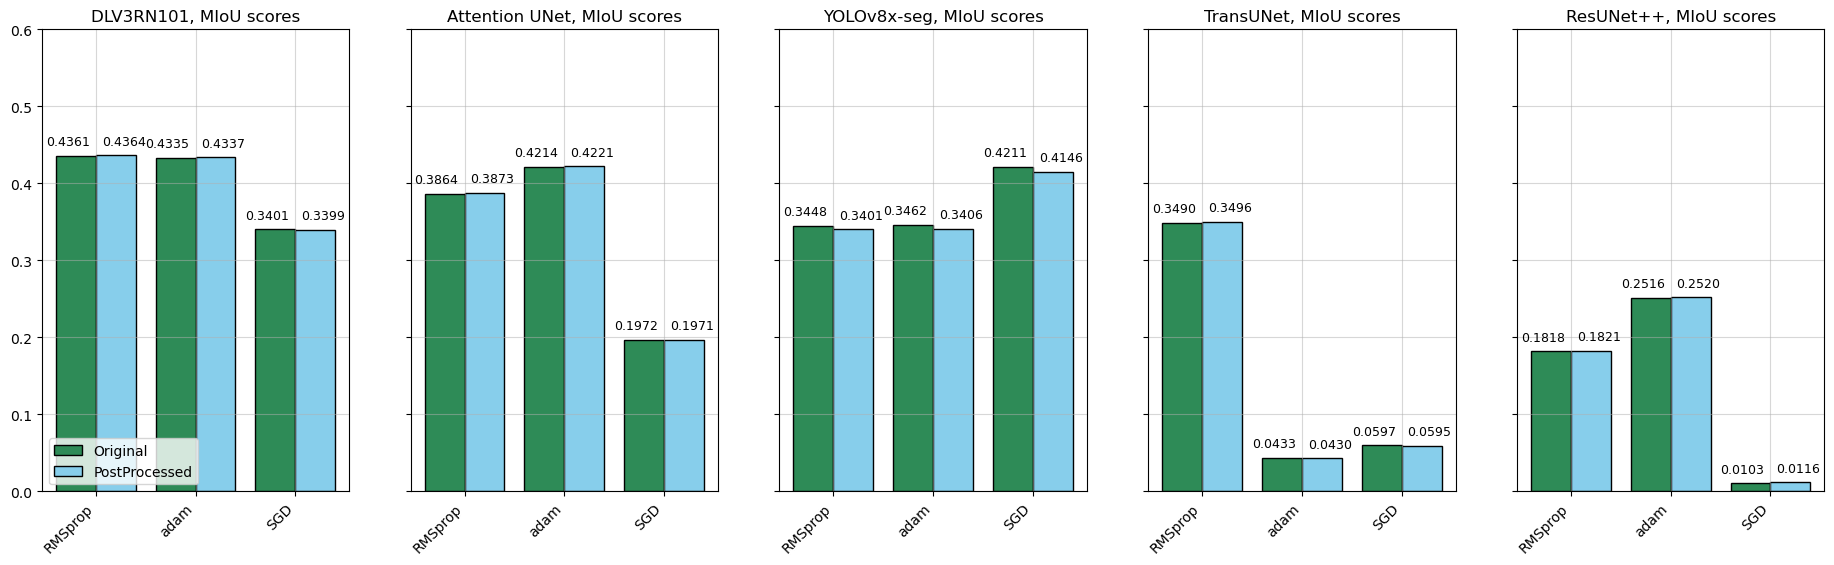

In [13]:
x = np.arange(len(data) // 3)
width = 0.4

fig, (ax,ax1,ax2,ax3,ax4) = plt.subplots(1,5,figsize=(23,6), sharey=True)

plot_bars(df_stores['deeplabv3resnet101'], 'Jaccard', width, x, ax)
ax.set(title='DLV3RN101, MIoU scores')
ax.legend(loc = 'lower left')

plot_bars(df_stores['attentionunet'], 'Jaccard', width, x, ax1)
ax1.set(title='Attention UNet, MIoU scores')

plot_bars(df_stores['yolov8x-seg'], 'Jaccard', width, x, ax2)
ax2.set(title='YOLOv8x-seg, MIoU scores')

plot_bars(df_stores['transunet'], 'Jaccard', width, x, ax3)
ax3.set(title='TransUNet, MIoU scores')

plot_bars(df_stores['resunetplusplus'], 'Jaccard', width, x, ax4)
ax4.set(title='ResUNet++, MIoU scores')

plt.ylim(0,0.6)
plt.show()

## Comments: Best optimisers for top three models
 - DLV3RN101 (PostProc) = **RMSprop** @ 0.5797
 - AUN (PostProc) = **Adam** @ 0.5620
 - Yolo = **SGD** @ 0.5495
 - TransUNet (PostProc) = **RMSprop** @ 0.3496
 - ResUNet++ (PostProc) = **Adam** @ 0.2520

# Modifications to Attention Unet
- Attention UNet: UNet with attention gates
- AUNET1: Add deformable convolutions to encoder blocks (in the hopes it would pick up abstract stenosis better)
- AUNET2: Add ASPP bridge (better long range dependancies, inspired by DLV3RN101 and ResUNet++)
- AUNET3 Added residual bottlenecks in place of encoder convolutions onto AUNET2 (inspired by DLV3RN101)

In [ ]:
mod_data = pd.read_csv('scores/mod_scores.csv', index_col='Model')
add_pp_label(mod_data)
mod_data

,Jaccard,F1,Recall,Precision,Acc,F2,HD,MFPS,MSPF
attentionunet,0.4214,0.5618,0.6339,0.5879,0.9912,0.5904,3.4743,498.900611,0.000007
attentionunet (PostProc),0.4221,0.5620,0.6331,0.5930,0.9913,0.5901,3.4774,498.900611,0.000007
aunet1,0.4007,0.5408,0.5966,0.6047,0.9912,0.5619,3.5407,254.219656,0.000013
aunet1 (PostProc),0.4012,0.5409,0.5957,0.6119,0.9912,0.5614,3.5543,254.219656,0.000013
aunet2,0.4226,0.5667,0.6328,0.5922,0.9914,0.5923,3.4909,398.254542,0.000008
aunet2 (PostProc),0.4231,0.5671,0.6325,0.5969,0.9914,0.5923,3.4917,398.254542,0.000008
aunet3,0.3911,0.5301,0.5847,0.5707,0.9910,0.5498,3.5947,342.394213,0.000010
aunet3 (PostProc),0.3921,0.5308,0.5840,0.5767,0.9911,0.5498,3.6013,342.394213,0.000010


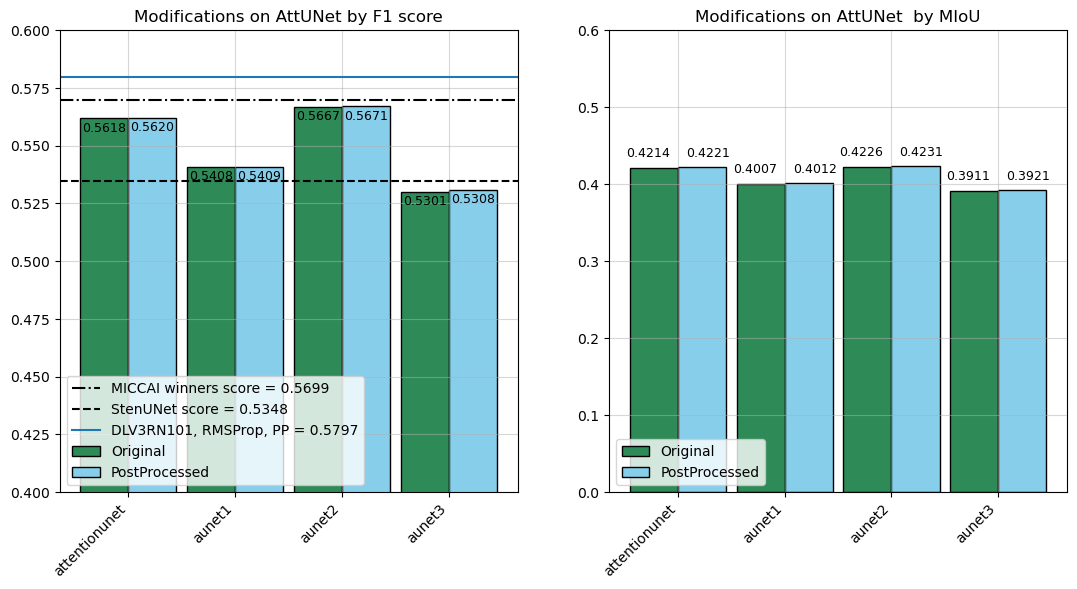

In [ ]:
import numpy as np

fig, (ax,ax1) = plt.subplots(1,2,figsize=(13,6))
x = np.arange(len(mod_data) // 2)
width = 0.45

ax.bar(x - width/2, mod_data['F1'][::2], width, edgecolor='black', color='seagreen', label='Original')
ax.bar(x + width/2, mod_data['F1'][1::2], width, edgecolor='black', color='skyblue', label='PostProcessed')

for i, (v1, v2) in enumerate(zip(mod_data['F1'][::2], mod_data['F1'][1::2])):
    ax.text(i - width/2, v1 - 0.007, f"{v1:.4f}", ha='center', va='bottom', fontsize=9)
    ax.text(i + width/2, v2 - 0.007, f"{v2:.4f}", ha='center', va='bottom', fontsize=9)

ax.set_xticks(x)
ax.set_xticklabels(mod_data.index[::2], rotation=45, ha='right')

ax.axhline(0.5699, color='black', linestyle='dashdot', label='MICCAI winners score = 0.5699')
ax.axhline(0.5348, color='black', linestyle='dashed', label='StenUNet score = 0.5348')
ax.axhline(0.5797, label='DLV3RN101, RMSProp, PP = 0.5797')

ax.grid(alpha=0.5)
ax.set(title='Modifications on AttUNet by F1 score')
ax.legend(loc='lower left')
ax.set_ylim(0.4,0.6)

plot_bars(mod_data, 'Jaccard', width, x, ax1)
ax1.set(title='Modifications on AttUNet  by MIoU')
ax1.legend(loc='lower left')

ax1.set_ylim(0, 0.6)
plt.show()

# Comments
- Small improvement with ASPP bridge (aunet 2), otherwise any other modifications reduced performance slightly

In [ ]:
import torchvision
import torch
from torch import nn
from torchinfo import summary

model = torchvision.models.segmentation.deeplabv3_resnet101(weights='DEFAULT', progress=True, aux_loss=None)
model.classifier[4] = nn.Conv2d(256, 1, kernel_size=1)

summary(model, (1,3,256,256))

Layer (type:depth-idx)                             Output Shape              Param #
DeepLabV3                                          [1, 21, 256, 256]         --
├─IntermediateLayerGetter: 1-1                     [1, 2048, 32, 32]         --
│    └─Conv2d: 2-1                                 [1, 64, 128, 128]         9,408
│    └─BatchNorm2d: 2-2                            [1, 64, 128, 128]         128
│    └─ReLU: 2-3                                   [1, 64, 128, 128]         --
│    └─MaxPool2d: 2-4                              [1, 64, 64, 64]           --
│    └─Sequential: 2-5                             [1, 256, 64, 64]          --
│    │    └─Bottleneck: 3-1                        [1, 256, 64, 64]          75,008
│    │    └─Bottleneck: 3-2                        [1, 256, 64, 64]          70,400
│    │    └─Bottleneck: 3-3                        [1, 256, 64, 64]          70,400
│    └─Sequential: 2-6                             [1, 512, 32, 32]          --
│    │    └─Bottlen